In [11]:
import numpy as np
import cvxpy as cp
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import sympy as sym
from matplotlib.ticker import MaxNLocator
import qutip as q
tol = 1e-9
plt.rcParams['font.size'] = 100
plt.rcParams['font.family'] = 'serif'
plt.rcParams["figure.figsize"] = (48,27)
plt.rcParams['legend.fontsize'] = 100
plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['mathtext.rm'] =  'Times New Roman'
# plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
# plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
# plt.rcParams['mathtext.cal'] = 'cursive'
plt.rcParams['axes.linewidth'] = 5
plt.rcParams['xtick.major.pad']='15'
plt.rcParams['ytick.major.pad']='15'
tol = 1e-30

In [12]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [13]:
class channel:
    
    def __init__(self, n, A_list):
        self.n = n
        self.A_list = A_list
        return
    
    def operate(self, rho):
        rho_out = rho*0
        for A in self.A_list:
            rho_out = rho_out + A*rho*A.dag()
        return rho_out
    
def Rotation(G, theta, l1, l2, d):
    U = np.identity(d,dtype=np.complex128)
    Rot = (-1j*theta*G/2).expm()
    U[l1,l1], U[l1,l2], U[l2,l1], U[l2,l2] = Rot[0,0], Rot[0,1], Rot[1,0], Rot[1,1]
    return q.Qobj(U)
    

In [4]:
proj1 = q.Qobj([[0,0],[0,1]])
proj0 = q.Qobj([[1,0],[0,0]])
I = q.identity(2)
X = q.sigmax()
Y = q.sigmay()
Z = q.sigmaz()
    

class VQ_HT:
    
    def __init__(self, map0, map1, layers1, layers2):
        self.map0 = map0
        self.map1 = map1
        self.U_layers = layers1
        self.V_layers = layers2
        self.init = q.tensor(q.tensor(q.fock_dm(2),q.fock_dm(2)),
                             q.tensor(q.fock_dm(2),q.fock_dm(2)))
        self.U_theta = np.zeros(12*(layers1+1))
        self.V_theta = np.zeros(18*(layers2+1))
        self.U = q.tensor(q.tensor(I,I),q.tensor(I,I))
        self.V = q.tensor(I,q.tensor(q.tensor(I,I),q.tensor(I,I)))
        
    def true_TD(self):
        rho = self.U*self.init*self.U.dag()
        rho0 = self.map0.operate(rho)
        rho1 = self.map1.operate(rho)
        return (rho0-rho1).norm()
    
    def estimate_TD(self,rho=None):
        if rho == None:
            rho = self.U*self.init*self.U.dag()
        Pi_0 = q.tensor(proj0,q.tensor(q.tensor(I,I),q.tensor(I,I)))
        rho0 = self.V*q.tensor(proj0,self.map0.operate(rho))*self.V.dag()
        rho1 = self.V*q.tensor(proj0,self.map1.operate(rho))*self.V.dag()
        return 2*abs(np.trace(Pi_0*rho0) - np.trace(Pi_0*rho1))
        
    def evaluate_U(self):
        th = self.U_theta
        U = q.tensor(q.tensor(I,I),q.tensor(I,I))
        for i in range(self.U_layers+1):
            rotation = q.rz(th[i*12 + 0])*q.rx(th[i*12 + 1])*q.rz(th[i*12 + 2])
            for j in range(1,4):
                rotation = q.tensor(rotation,q.rz(th[i*12 + 3*j + 0])*q.rx(th[i*12 + 3*j + 1])*q.rz(th[i*12 + 3*j + 2]))
            U = rotation*U
            if i < self.U_layers:
                U = (q.tensor(q.tensor(proj0,I),q.tensor(I,I)) + 
                     q.tensor(q.tensor(proj1,Z),q.tensor(I,I)))*U
#                 U = (q.tensor(q.tensor(I,I),q.tensor(proj0,I)) + 
#                      q.tensor(q.tensor(I,I),q.tensor(proj1,Z)))*U
                U = (q.tensor(q.tensor(I,proj0),q.tensor(I,I)) + 
                     q.tensor(q.tensor(I,proj1),q.tensor(Z,I)))*U
                U = (q.tensor(q.tensor(I,I),q.tensor(I,proj0)) + 
                     q.tensor(q.tensor(Z,I),q.tensor(I,proj1)))*U
        self.U = U
    
                     
    def evaluate_V(self):
        th = self.V_theta
        V = q.tensor(II,q.tensor(q.tensor(I,I),q.tensor(I,I)))
        for i in range(self.V_layers+1):
            rotation = q.rz(th[i*12 + 0])*q.rx(th[i*12 + 1])*q.rz(th[i*12 + 2])
            for j in range(1,5):
                rotation = q.tensor(rotation,q.rz(th[i*12 + 3*j + 0])*q.rx(th[i*12 + 3*j + 1])*q.rz(th[i*12 + 3*j + 2]))
            V = rotation*V
            if i < self.V_layers:
                V = (q.tensor(I,q.tensor(q.tensor(proj0,I),q.tensor(I,I)) + 
                     q.tensor(q.tensor(proj1,Z),q.tensor(I,I))))*V
#                 V = (q.tensor(I,q.tensor(q.tensor(I,I),q.tensor(proj0,I)) + 
#                      q.tensor(q.tensor(I,I),q.tensor(proj1,Z))))*V
                V = (q.tensor(I,q.tensor(q.tensor(I,I),q.tensor(proj0,I)) + 
                     q.tensor(q.tensor(Z,I),q.tensor(proj1,I))))*V
                V = (q.tensor(I,q.tensor(q.tensor(I,proj0),q.tensor(I,I)) + 
                     q.tensor(q.tensor(I,proj1),q.tensor(I,Z))))*V
                V = (q.tensor(proj0,q.tensor(q.tensor(I,I),q.tensor(I,I))) + 
                     q.tensor(proj1,q.tensor(q.tensor(I,I),q.tensor(I,Z))))*V    
                V = (q.tensor(proj0,q.tensor(q.tensor(I,I),q.tensor(I,I))) + 
                     q.tensor(proj1,q.tensor(q.tensor(Z,I),q.tensor(I,I))))*V
        self.V = V

    def _cost(self,x):
        self.U_theta = x[:len(self.U_theta)]
        self.V_theta = x[len(self.U_theta):]
        self.evaluate_U()
        self.evaluate_V()
        rho = self.U*self.init*self.U.dag()
        return -self.estimate_TD(rho)
    
    def _cost_tru(self,x):
        self.U_theta = x
        self.evaluate_U()
        return -self.true_TD()
    
    def optimize(self):
        x0 = np.random.uniform(-np.pi,np.pi,size=len(self.U_theta)+len(self.V_theta))
        opti = scipy.optimize.minimize(self._cost,x0=x0)
        self.U_theta = opti.x[:len(self.U_theta)]
        self.V_theta = opti.x[len(self.U_theta):]
        self.evaluate_U()
        self.evaluate_V()
        print(-opti.fun,self.true_TD())
        
    def optimize_trueTD(self):
        x0 = np.random.uniform(-np.pi,np.pi,size=len(self.U_theta))
        opti = scipy.optimize.minimize(self._cost_tru,x0=x0)
        self.U_theta = opti.x[:len(self.U_theta)]
        self.evaluate_U()
        print(-opti.fun,self.true_TD())

In [5]:
pproj0 = q.Qobj([[1,0,0],[0,0,0],[0,0,0]])
pproj1 = q.Qobj([[0,0,0],[0,1,0],[0,0,0]])
pproj2 = q.Qobj([[0,0,0],[0,0,0],[0,0,1]])
II = q.identity(3)
XX = q.sigmax()
YY = q.sigmay()
ZY = q.sigmaz()


class mult_VQ_HT:
    
    def __init__(self, map0, map1, map2, layers1, layers2):
        self.map0 = map0
        self.map1 = map1
        self.map2 = map2
        self.U_layers = layers1
        self.V_layers = layers2
        self.init = q.tensor(q.tensor(q.fock_dm(2),q.fock_dm(2)),
                             q.tensor(q.fock_dm(2),q.fock_dm(2)))
        self.U_theta = np.zeros(12*(layers1+1))
        self.V_theta = np.zeros(15*(layers2+1))
        self.U = q.tensor(q.tensor(I,I),q.tensor(I,I))
        self.V = q.tensor(I,q.tensor(q.tensor(I,I),q.tensor(I,I)))

    
    def estimate_TD(self,rho=None):
        if rho == None:
            rho = self.U*self.init*self.U.dag()
        Pi_0 = q.tensor(pproj0,q.tensor(q.tensor(I,I),q.tensor(I,I)))
        Pi_1 = q.tensor(pproj1,q.tensor(q.tensor(I,I),q.tensor(I,I)))
        Pi_2 = q.tensor(pproj2,q.tensor(q.tensor(I,I),q.tensor(I,I)))
        rho0 = self.V*q.tensor(proj0,self.map0.operate(rho))*self.V.dag()
        rho1 = self.V*q.tensor(proj1,self.map1.operate(rho))*self.V.dag()
        rho2 = self.V*q.tensor(proj2,self.map1.operate(rho))*self.V.dag()
        return np.trace((Pi_0*rho0).full()) + np.trace((Pi_1*rho1).full()) + np.trace((Pi_2*rho2).full())
        
    def evaluate_U(self):
        th = self.U_theta
        U = q.tensor(q.tensor(I,I),q.tensor(I,I))
        for i in range(self.U_layers+1):
            rotation = q.rz(th[i*12 + 0])*q.rx(th[i*12 + 1])*q.rz(th[i*12 + 2])
            for j in range(1,4):
                rotation = q.tensor(rotation,q.rz(th[i*12 + 3*j + 0])*q.rx(th[i*12 + 3*j + 1])*q.rz(th[i*12 + 3*j + 2]))
            U = rotation*U
            if i < self.U_layers:
                U = (q.tensor(q.tensor(proj0,I),q.tensor(I,I)) + 
                     q.tensor(q.tensor(proj1,Z),q.tensor(I,I)))*U
#                 U = (q.tensor(q.tensor(I,I),q.tensor(proj0,I)) + 
#                      q.tensor(q.tensor(I,I),q.tensor(proj1,Z)))*U
                U = (q.tensor(q.tensor(I,proj0),q.tensor(I,I)) + 
                     q.tensor(q.tensor(I,proj1),q.tensor(Z,I)))*U
                U = (q.tensor(q.tensor(I,I),q.tensor(I,proj0)) + 
                     q.tensor(q.tensor(Z,I),q.tensor(I,proj1)))*U
        self.U = U
        
    def evaluate_V(self):
        th = self.V_theta
        V = q.tensor(I,q.tensor(q.tensor(I,I),q.tensor(I,I)))
        for i in range(self.V_layers+1):
            rotation = Rotation(Z, th[i*18 + 0], 0, 1, 3)*Rotation(X, th[i*18 + 1], 0, 1, 3)*Rotation(Z, th[i*18 + 2], 0, 1, 3)
            rotation = rotation*Rotation(Z, th[i*18 + 3], 1, 2, 3)*Rotation(X, th[i*18 + 4], 1, 2, 3)*Rotation(Z, th[i*18 + 5], 1, 2, 3)
            for j in range(2,6):
                rotation = q.tensor(rotation,q.rz(th[i*18 + 3*j + 0])*q.rx(th[i*18 + 3*j + 1])*q.rz(th[i*18 + 3*j + 2]))
            V = rotation*V
            if i < self.V_layers:
                V = (q.tensor(II,q.tensor(q.tensor(proj0,I),q.tensor(I,I)) + 
                     q.tensor(q.tensor(proj1,Z),q.tensor(I,I))))*V
#                 V = (q.tensor(I,q.tensor(q.tensor(I,I),q.tensor(proj0,I)) + 
#                      q.tensor(q.tensor(I,I),q.tensor(proj1,Z))))*V
                V = (q.tensor(II,q.tensor(q.tensor(I,I),q.tensor(proj0,I)) + 
                     q.tensor(q.tensor(Z,I),q.tensor(proj1,I))))*V
                V = (q.tensor(II,q.tensor(q.tensor(I,proj0),q.tensor(I,I)) + 
                     q.tensor(q.tensor(I,proj1),q.tensor(I,Z))))*V
                V = (q.tensor(pproj0+pproj2,q.tensor(q.tensor(I,I),q.tensor(I,I))) + 
                     q.tensor(pproj1,q.tensor(q.tensor(I,I),q.tensor(I,Z))))*V
                V = (q.tensor(pproj0+pproj1,q.tensor(q.tensor(I,I),q.tensor(I,I))) + 
                     q.tensor(pproj2,q.tensor(q.tensor(I,I),q.tensor(I,Z))))*V
                V = (q.tensor(pproj0+pproj2,q.tensor(q.tensor(I,I),q.tensor(I,I))) + 
                     q.tensor(pproj1,q.tensor(q.tensor(Z,I),q.tensor(I,I))))*V
                V = (q.tensor(pproj0+pproj2,q.tensor(q.tensor(I,I),q.tensor(I,I))) + 
                     q.tensor(pproj2,q.tensor(q.tensor(Z,I),q.tensor(I,I))))*V
        self.V = V
        
    def _cost(self,x):
        self.U_theta = x[:len(self.U_theta)]
        self.V_theta = x[len(self.U_theta):]
        self.evaluate_U()
        self.evaluate_V()
        rho = self.U*self.init*self.U.dag()
        return -self.estimate_TD(rho)
    
    
    def optimize(self):
        x0 = np.random.uniform(-np.pi,np.pi,size=len(self.U_theta)+len(self.V_theta))
        opti = scipy.optimize.minimize(self._cost,x0=x0)
        self.U_theta = opti.x[:len(self.U_theta)]
        self.V_theta = opti.x[len(self.U_theta):]
        self.evaluate_U()
        self.evaluate_V()
        print(-opti.fun,self.true_TD())
        
    def optimize_trueTD(self):
        x0 = np.random.uniform(-np.pi,np.pi,size=len(self.U_theta))
        opti = scipy.optimize.minimize(self._cost_tru,x0=x0)
        self.U_theta = opti.x[:len(self.U_theta)]
        self.evaluate_U()
        print(-opti.fun,self.true_TD())

In [8]:
def unitary_diamond(U):
    eig = np.linalg.eigvals(U)
    eig_arr = np.array([eig]*len(eig))
    return np.amax(np.absolute(eig_arr - eig_arr.T))

In [9]:
def rand_U(N):
    transform = stats.unitary_group.rvs(N)
    eigs = np.exp(1j*np.random.normal(loc=np.pi,scale=np.pi/5,size=N))
    return transform@np.diagflat(eigs)@transform.T.conj()

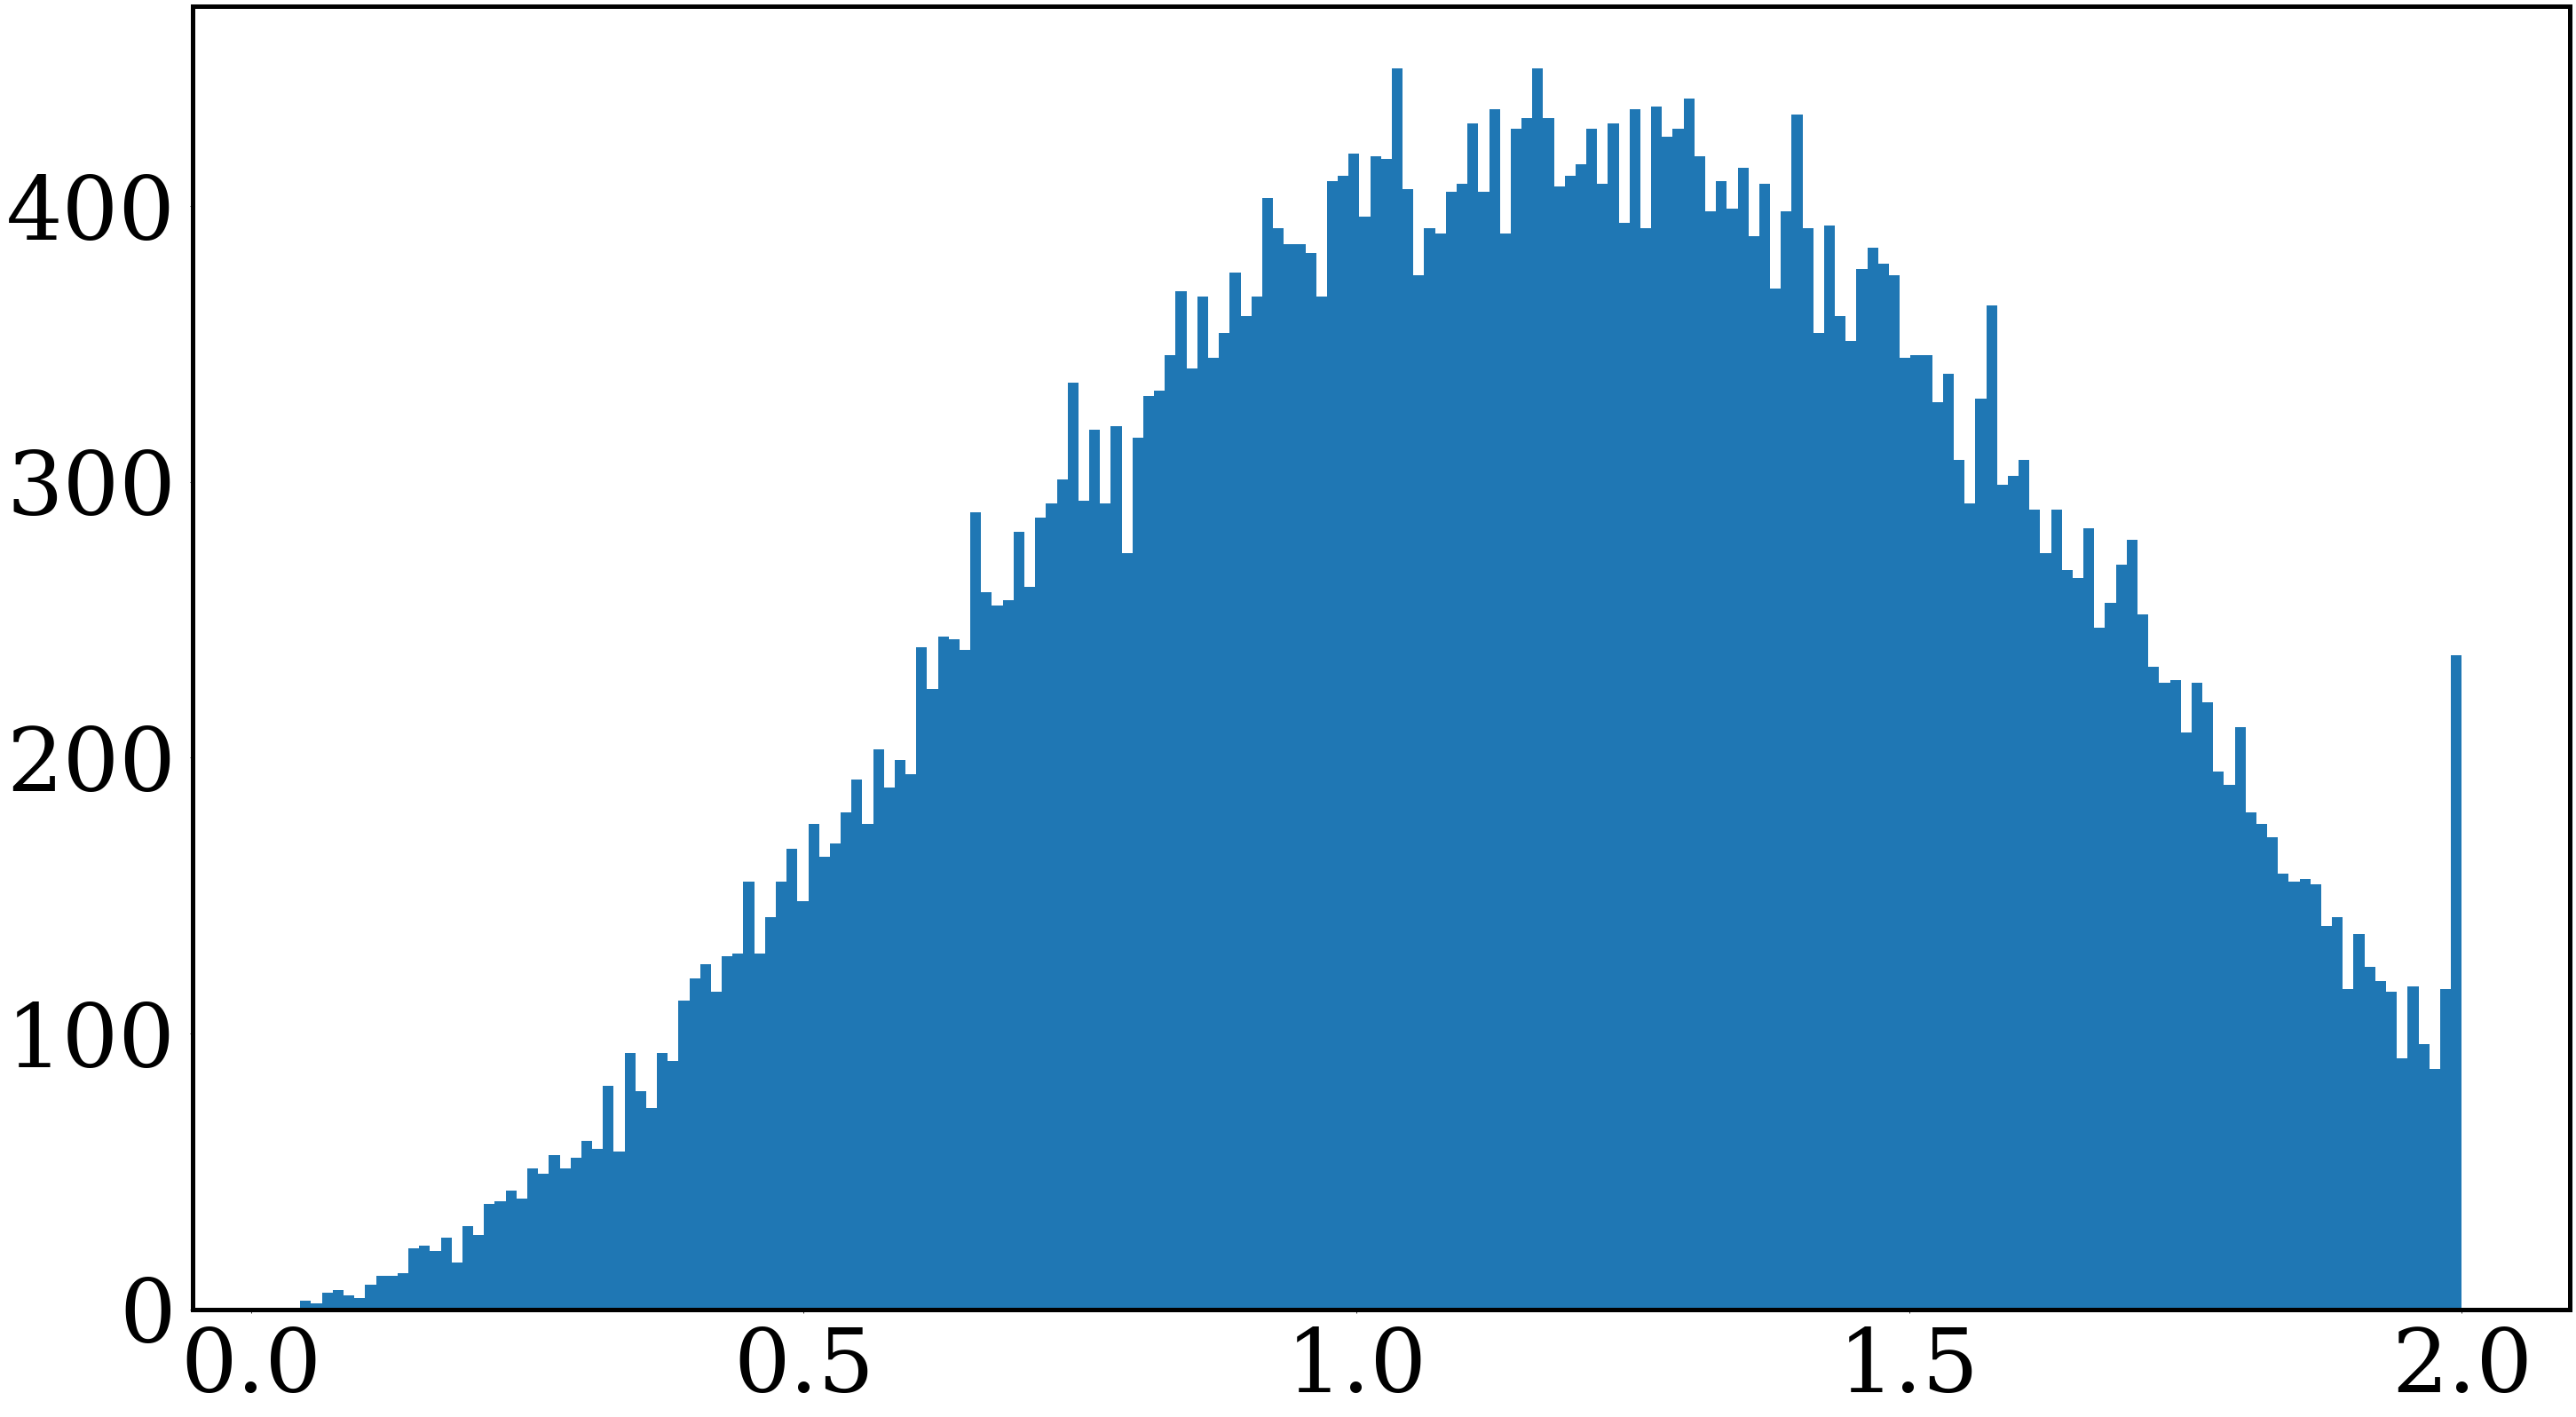

In [7]:
dnorm = []
for i in range(50000):
    dnorm.append(unitary_diamond(rand_U(4)))
A = plt.hist(dnorm,200)

In [7]:
U1 = rand_U(4)
map0 = channel(4,[q.tensor(q.tensor(I,I),q.tensor(I,I))])
map1 = channel(4,[q.tensor(q.Qobj(U1,dims=[[2,2],[2,2]]),q.tensor(I,I))])

In [8]:
unitary_diamond(U1)

0.6811374652653245

In [9]:
try1 = VQ_HT(map0,map1,1,1)
try1.optimize_trueTD()

0.6361236842794512 0.6361236842794512


In [10]:
try1.optimize()

0.5586345716112556 0.5972908014199916


In [12]:
print(try1.U_theta)

[ 5.05760726e-01  1.84992777e+00 -1.91116087e+00 -3.10507406e+00
 -2.41828262e+00 -1.40150744e-01  2.98417632e+00  1.93973581e-06
  3.13896844e+00 -3.35815031e+00  3.42098979e-05  1.73431149e+00
  1.79991679e+00 -8.59324612e-01 -8.80648752e-01 -6.14059950e-01
 -4.93409581e-01 -1.59575983e+00  1.37884284e+00  1.08902880e+00
 -1.09663072e+00 -1.72327879e-02  1.57078824e+00 -1.64416968e+00]


In [16]:
try1.U*q.tensor(q.tensor(q.fock(2),q.fock(2)),q.tensor(q.fock(2),q.fock(2)))

Quantum object: dims = [[2, 2, 2, 2], [1, 1, 1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.08828397+0.18325984j]
 [ 0.18171323-0.09142845j]
 [ 0.07365333+0.09874115j]
 [ 0.09745847-0.07534392j]
 [-0.069308  -0.10453215j]
 [-0.10333707+0.07109298j]
 [-0.05327782-0.05413299j]
 [-0.05321634+0.05420085j]
 [-0.08154052+0.11809066j]
 [ 0.11947555+0.07948522j]
 [-0.03482957+0.07962091j]
 [ 0.08020672+0.03344777j]
 [ 0.37227027+0.38671978j]
 [ 0.38023581-0.37887902j]
 [ 0.26597862+0.18688028j]
 [ 0.18226229-0.26915815j]]

In [12]:
print(abs(np.trace(try1.V*try1.optimal_V().dag())/np.trace(try1.V*try1.V.dag())))

0.033203169157084024


In [7]:
dnorms = []
trueTD = []
estTD = []
mapU = []
for i in range(50):
    UU = rand_U(4)
    mapU.append(UU)
    map0 = channel(4,[q.tensor(q.tensor(I,I),q.tensor(I,I))])
    map1 = channel(4,[q.tensor(q.Qobj(UU,dims=[[2,2],[2,2]]),q.tensor(I,I))])
    dnorms.append(unitary_diamond(UU))
    print(dnorms[-1])
    try1 = VQ_HT(map0,map1,1,1)
    try1.optimize()
    trueTD.append(try1.true_TD())
    estTD.append(try1.estimate_TD())
    print()

1.7661297619139729
1.5156071687892902 1.5618588720219873

1.2307095057971913
1.151350838070615 1.1827827122634478

0.8107155851440687
0.614621897024278 0.6967748981595139

0.8386516520778665
0.6269364756051696 0.713982982290129

1.3162645412681229
1.218604000394335 1.244563387630035

1.8164778315930268
1.7564906569485335 1.7679056180298245

1.2684427434685062
1.011493872893098 1.109165978854976

0.690022365579625
0.5996014298196379 0.6103675939096068

1.863428820365999
1.7473943027338 1.7877392729279467

1.1275147631712201
1.0884520590163997 1.1180687649159682

1.4230706600099485
1.3662645953574903 1.3835632590927744

0.973839569035423
0.8809918851262304 0.8899772955907072

1.3744099905766165
1.0317371335303087 1.238906848387884

1.495367339422136
1.4059824502092062 1.4265419772892094

0.859202056364314
0.8259302492728651 0.8536846032456449

1.0668748727647064
1.0498503832388533 1.0581755108364121

0.8208553224095821
0.7141762486725224 0.7507110158372884

1.2641147920837783
0.968673680

In [7]:
estTD = np.load("npy files/diamond_est_trace.npy")
trueTD = np.load("npy files/diamond_tru_trace.npy")
dnorms = np.load("npy files/diamond_norm.npy")

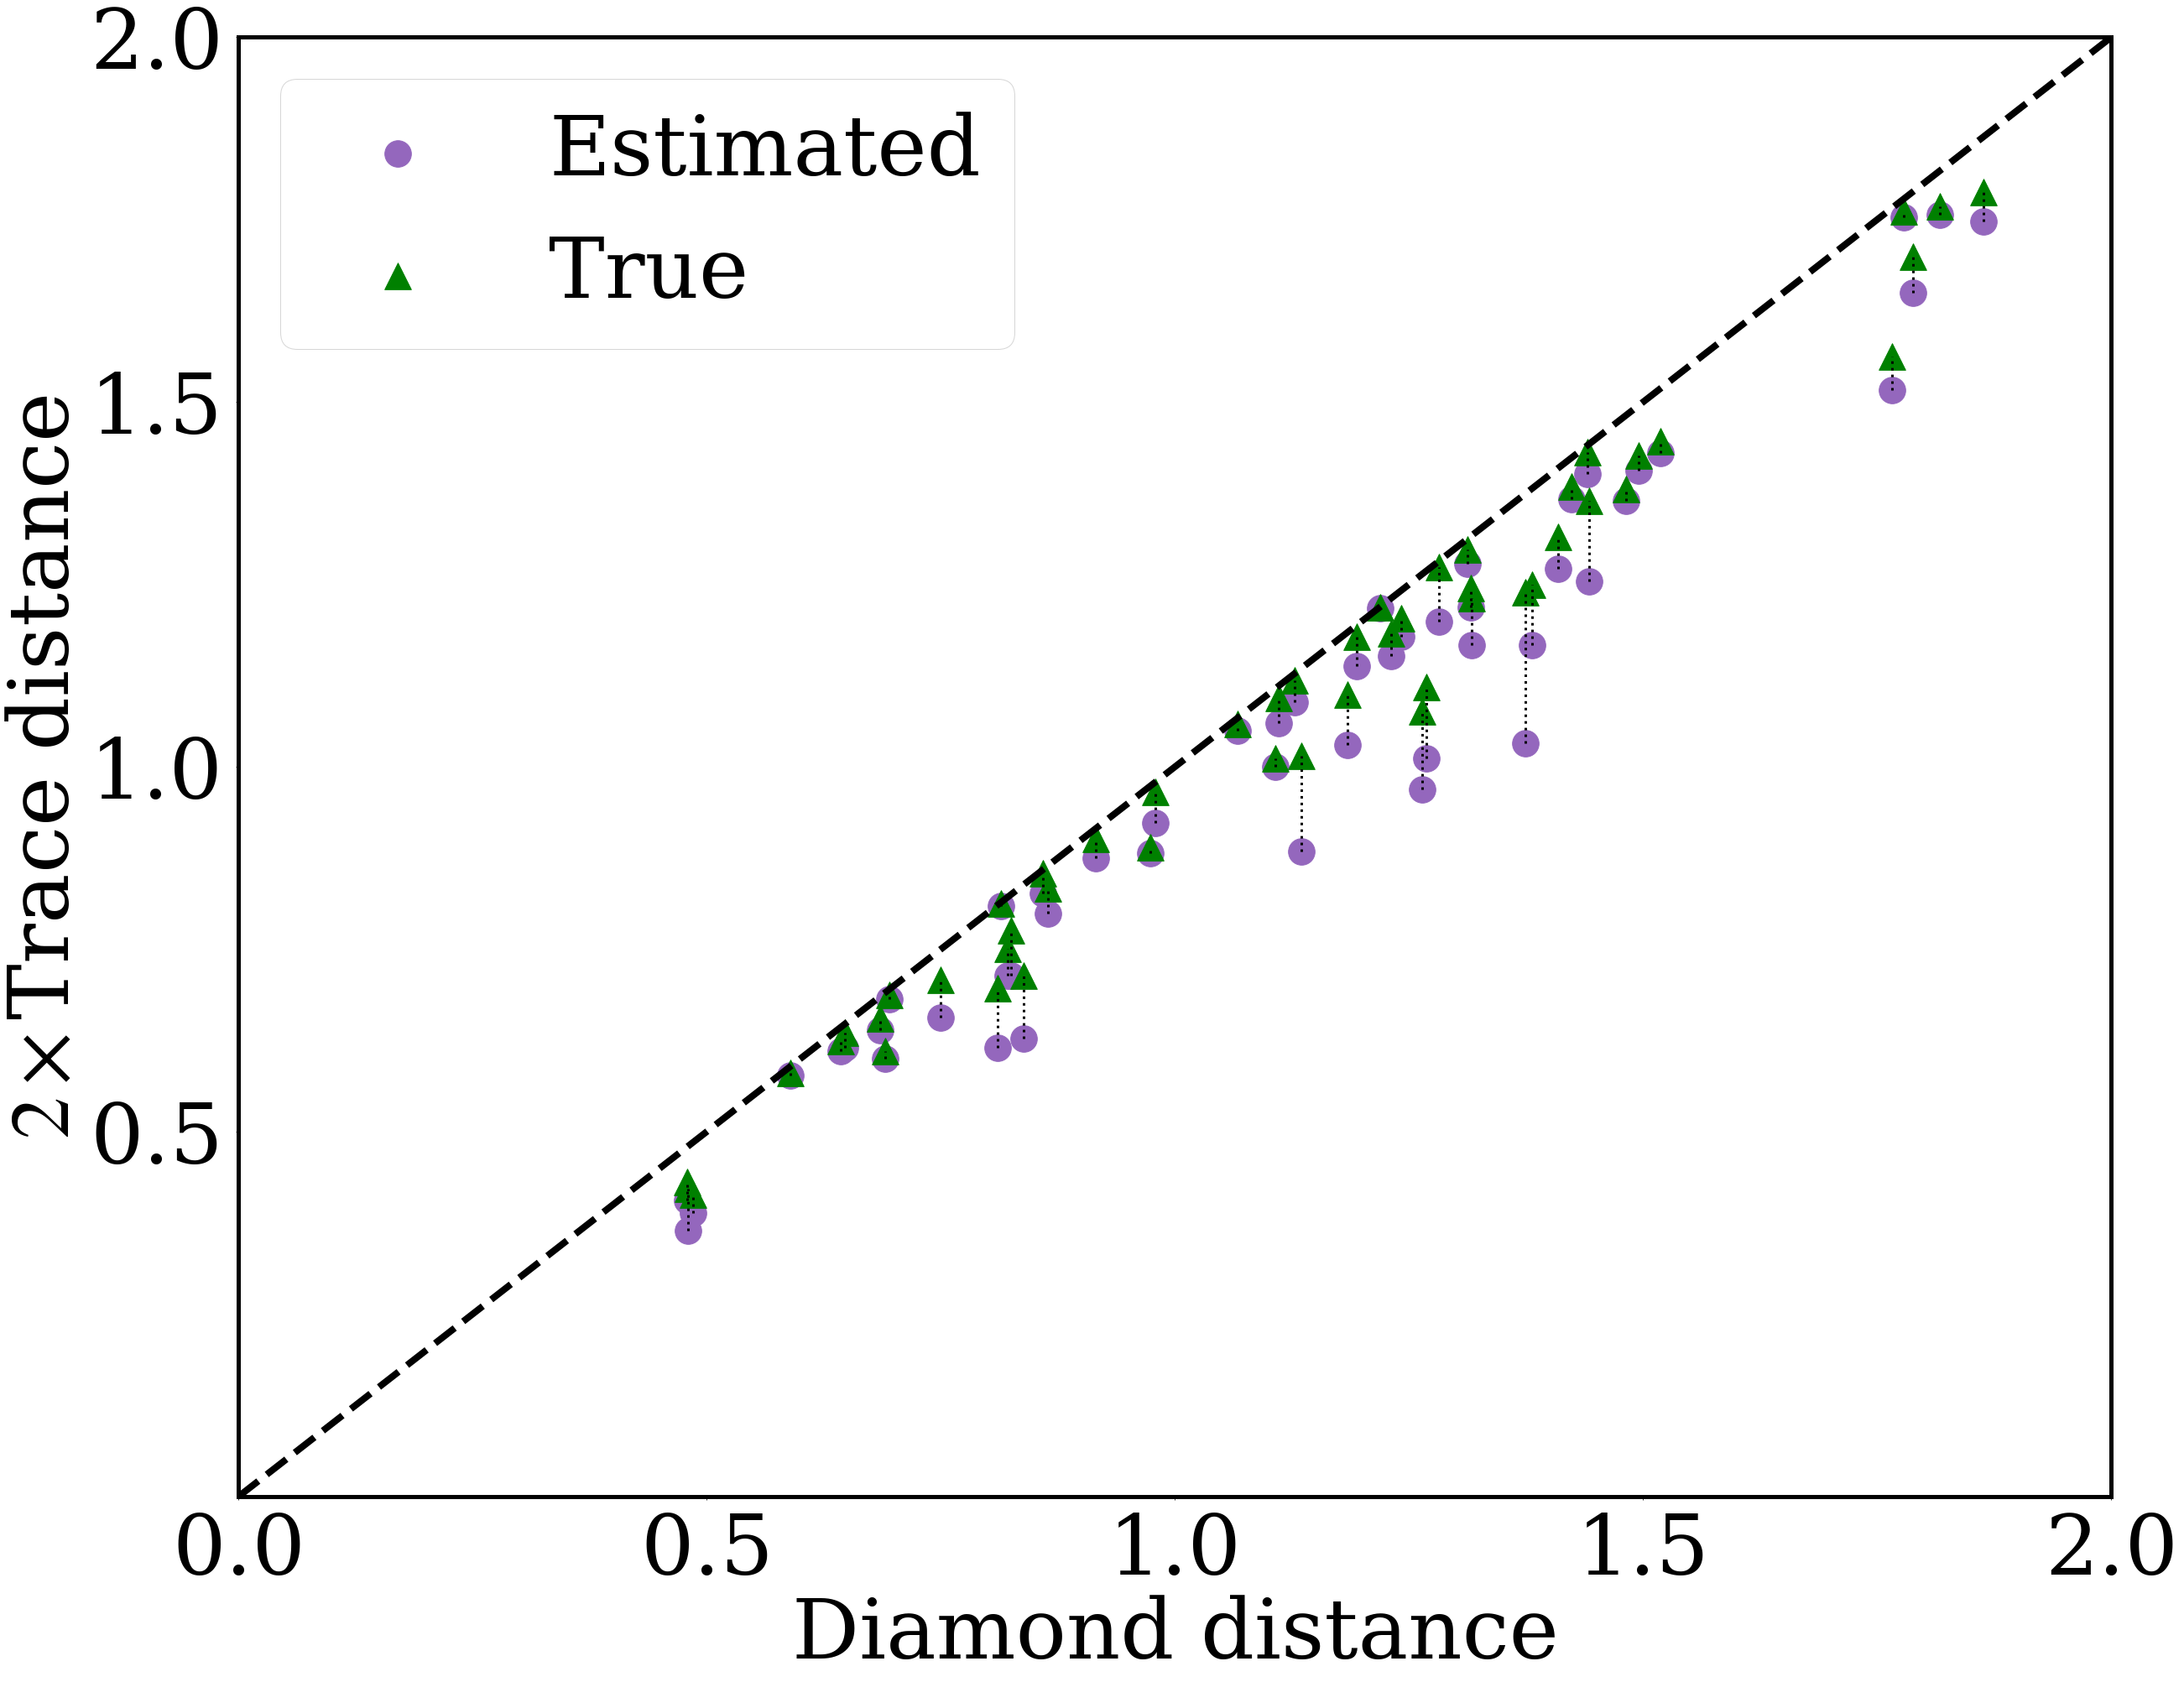

In [16]:
plt.rcParams["figure.figsize"] = (40,32)
plt.plot([0,2],[0,2],'k--',linewidth=8)
plt.xlim(0,2)
plt.ylim(0,2)
plt.xlabel("Diamond distance")
plt.yticks([0.5,1,1.5,2])
plt.ylabel(r"$2\times$Trace distance")
for i in range(len(estTD)):
    plt.plot([dnorms[i],dnorms[i]],[estTD[i],trueTD[i]],'k',linestyle='dotted',linewidth=3)
plt.scatter(dnorms,estTD,s=1000,label="Estimated",color="tab:purple")
plt.scatter(dnorms,trueTD,marker="^",s=1000,label="True",color="green")
plt.legend()

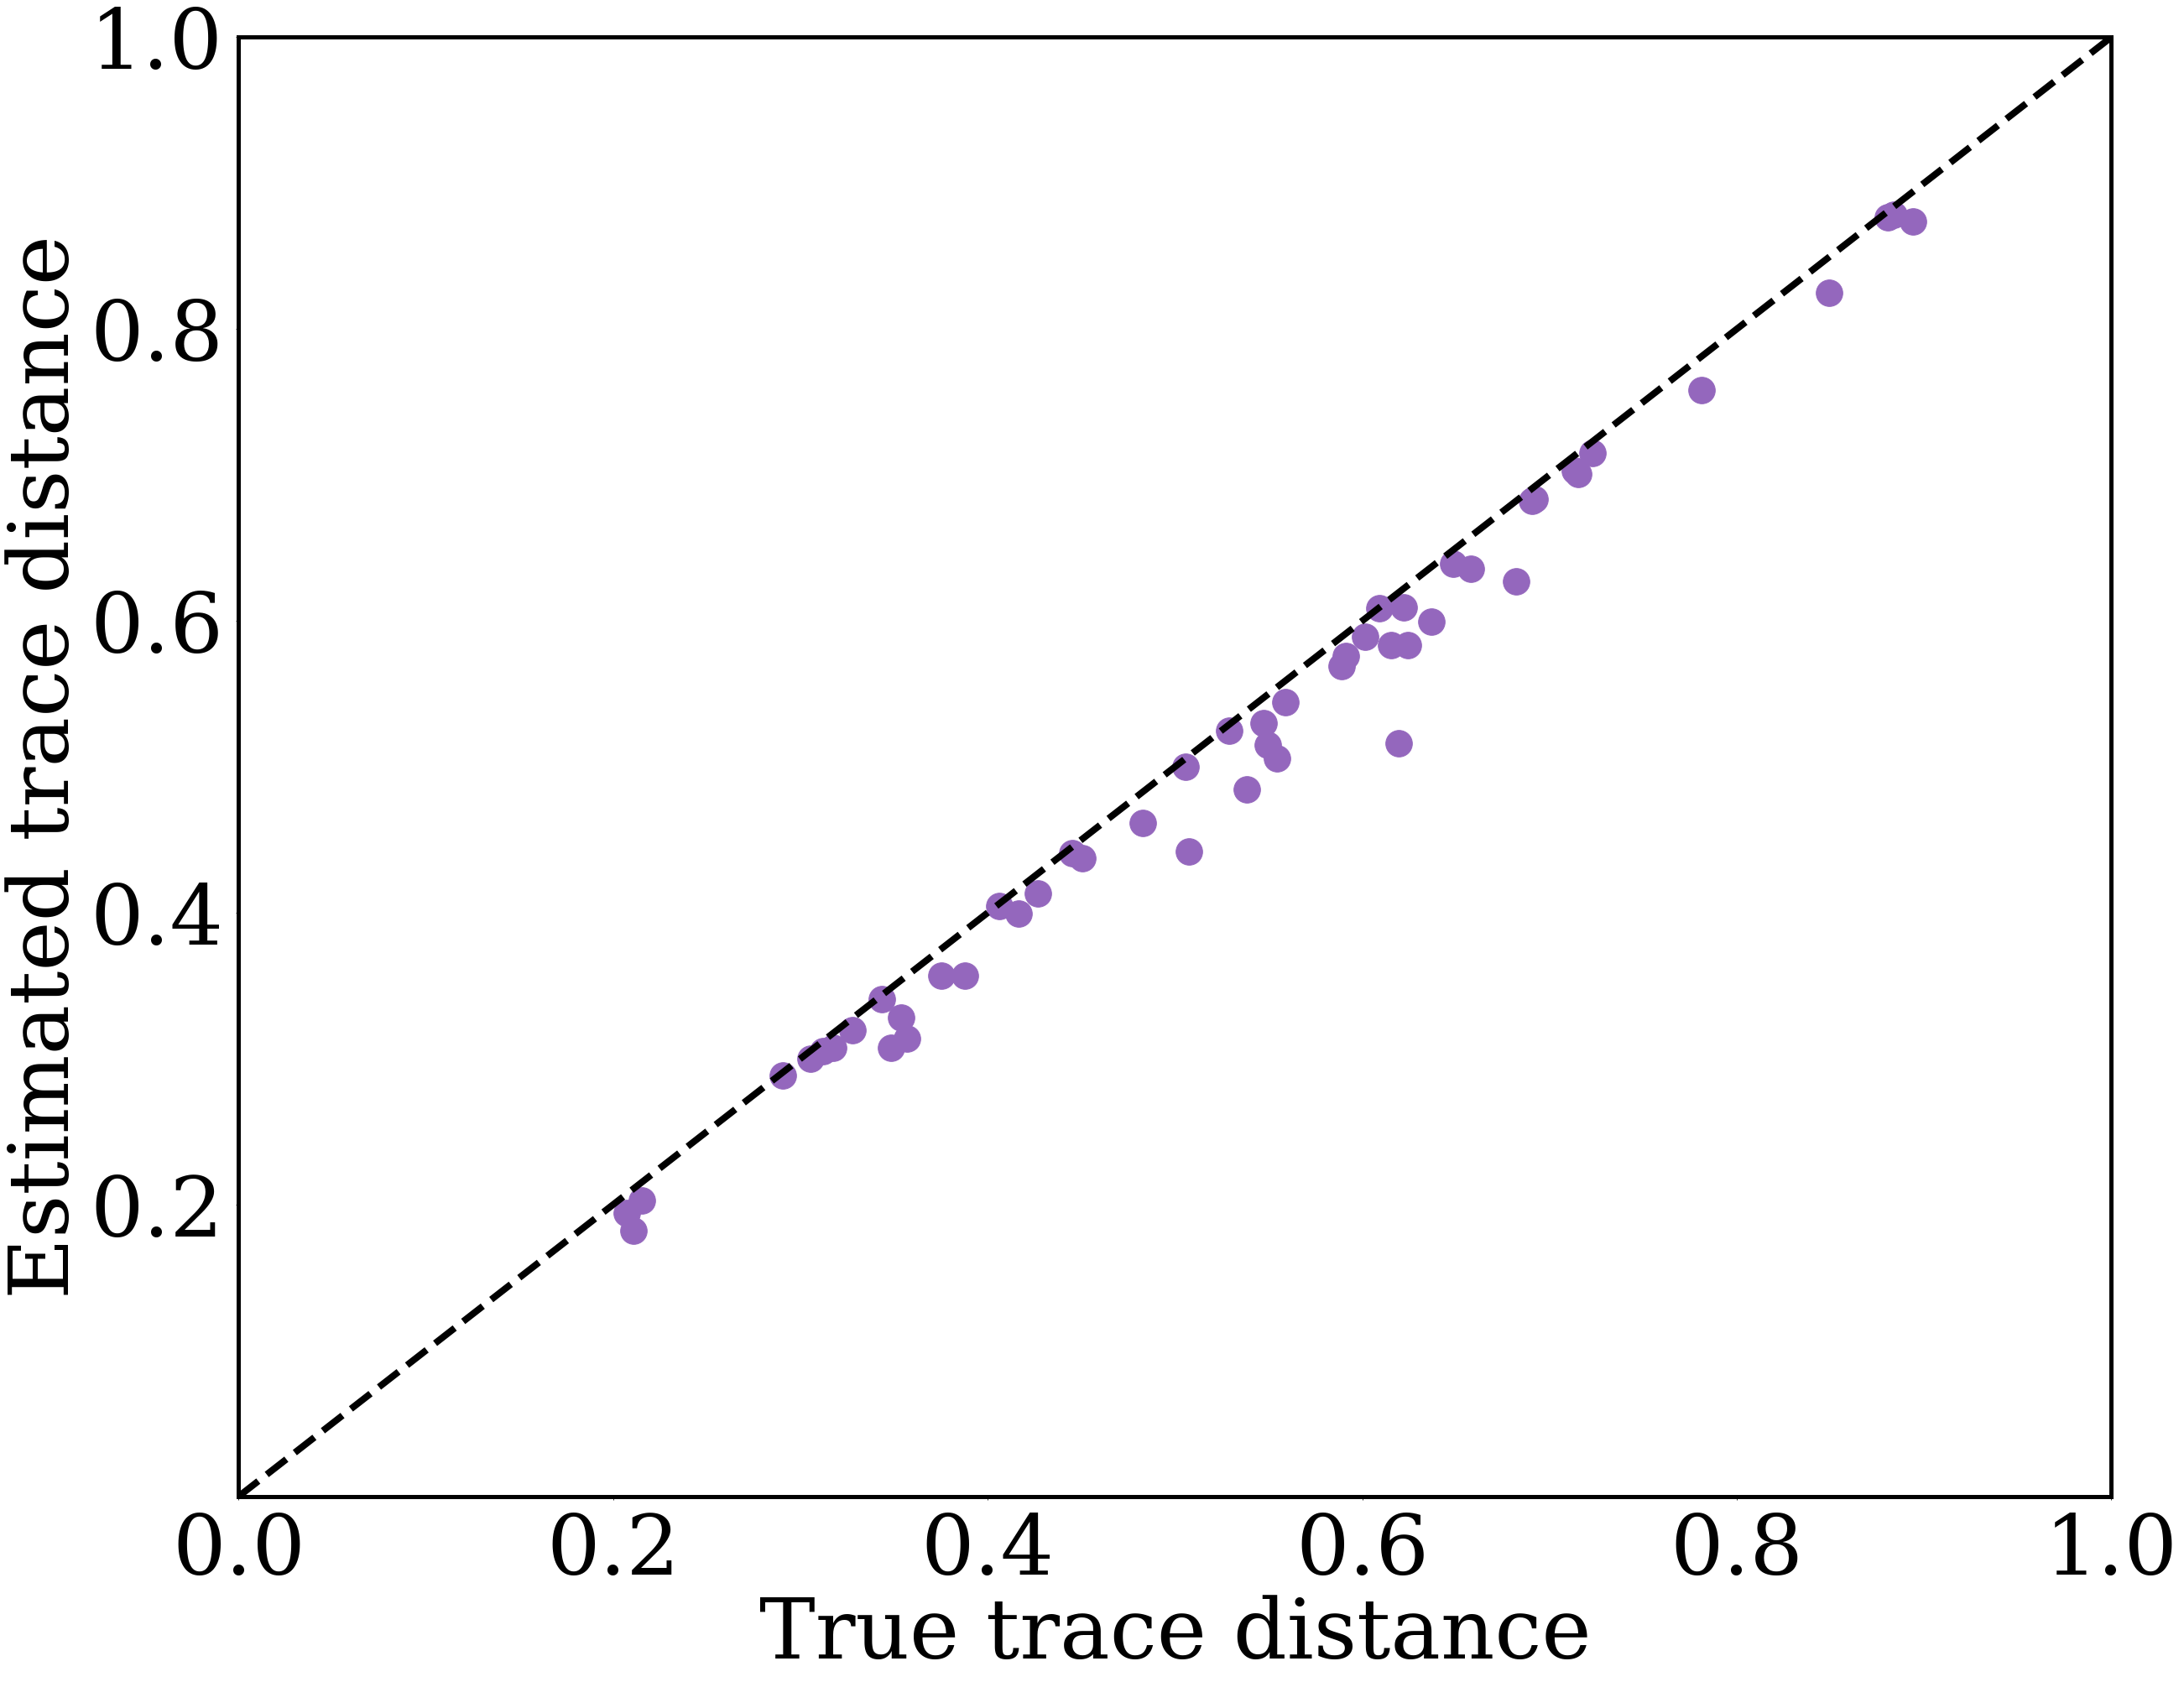

In [23]:
plt.rcParams["figure.figsize"] = (40,32)
plt.plot([0,1],[0,1],'k--',linewidth=8)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("True trace distance")
plt.yticks([0.2,0.4,0.6,0.8,1])
#plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))

plt.ylabel("Estimated trace distance")
plt.scatter(trueTD/2,estTD/2,s=1000,color="tab:purple")

In [10]:
np.save("data/diamond_est_trace.npy",estTD)
np.save("data/diamond_tru_trace.npy",trueTD)
np.save("data/diamond_norm.npy",dnorms)

In [13]:
map0 = channel(4,[q.tensor(q.tensor(I,I),q.tensor(I,I))])
rot = q.Qobj(U1,dims=[[2,2],[2,2]])
map1 = channel(4,[np.sqrt(0.5)*q.tensor(q.tensor(I,I),q.tensor(I,I)),np.sqrt(0.5)*q.tensor(rot*q.tensor(Z,Z)*rot.dag(),q.tensor(I,I))])
try2 = VQ_HT(map0,map1,1,1)
try2.optimize_trueTD()

0.9993866939135888 0.9993866939135888


In [17]:
map0 = channel(4,[q.tensor(q.tensor(I,I),q.tensor(I,I))])
map1 = channel(4,[np.sqrt(0.5)*q.tensor(q.tensor(I,I),q.tensor(I,I)),np.sqrt(0.5)*q.tensor(q.tensor(Z,Z),q.tensor(I,I))])
try2 = VQ_HT(map0,map1,1,1)
try2.optimize()

1.0000000000000095 1.0000000411897554


In [7]:
trueTD2 = []
estTD2 = []
cc = np.linspace(-0.5+1/50,0.5,50)
for c in cc:
    rot = q.Qobj(rand_U(4),dims=[[2,2],[2,2]])
    map0 = channel(4,[q.tensor(q.tensor(I,I),q.tensor(I,I))])
    map1 = channel(4,[np.sqrt(0.5-c)*q.tensor(q.tensor(I,I),q.tensor(I,I)),np.sqrt(0.5+c)*q.tensor(rot*q.tensor(Z,Z)*rot.dag(),q.tensor(I,I))])
    try22 = VQ_HT(map0,map1,1,1)
    try22.optimize()
    trueTD2.append(try22.true_TD())
    estTD2.append(try22.estimate_TD())

0.03999999972699232 0.04000000137807093
0.07995337233066498 0.08000000134144565
0.11985949523312311 0.11999998040274841
0.15999999931566666 0.16000000514539128
0.19999999997781723 0.20000000865069686
0.21618147847041447 0.2400000114253169
0.2796374357807858 0.28000001378430805
0.31911292658706625 0.3195562415966701
0.35999999989784137 0.3600000172183435
0.39999999937979686 0.4000000157252557
0.4399999999803226 0.4400000209841624
0.47999999996690856 0.48000001566273637
0.5199999998755409 0.5200000198322773
0.5599999995989828 0.5600000239007246
0.5991233364092121 0.6000000296641843
0.6358437450940444 0.6400000267516018
0.6760449253305816 0.680000032525979
0.719999999951821 0.7200000306971864
0.7599999930040378 0.7600000284849442
0.7999999999718497 0.8000000294734235
0.8399999999670593 0.8400000347744155
0.8773961509393076 0.8800000356819344
0.9199999999707751 0.9200000423905381
0.9599999999267813 0.9600000464825332
0.9996655803347931 0.9998328187653779
1.0277056062166037 1.04000005400509

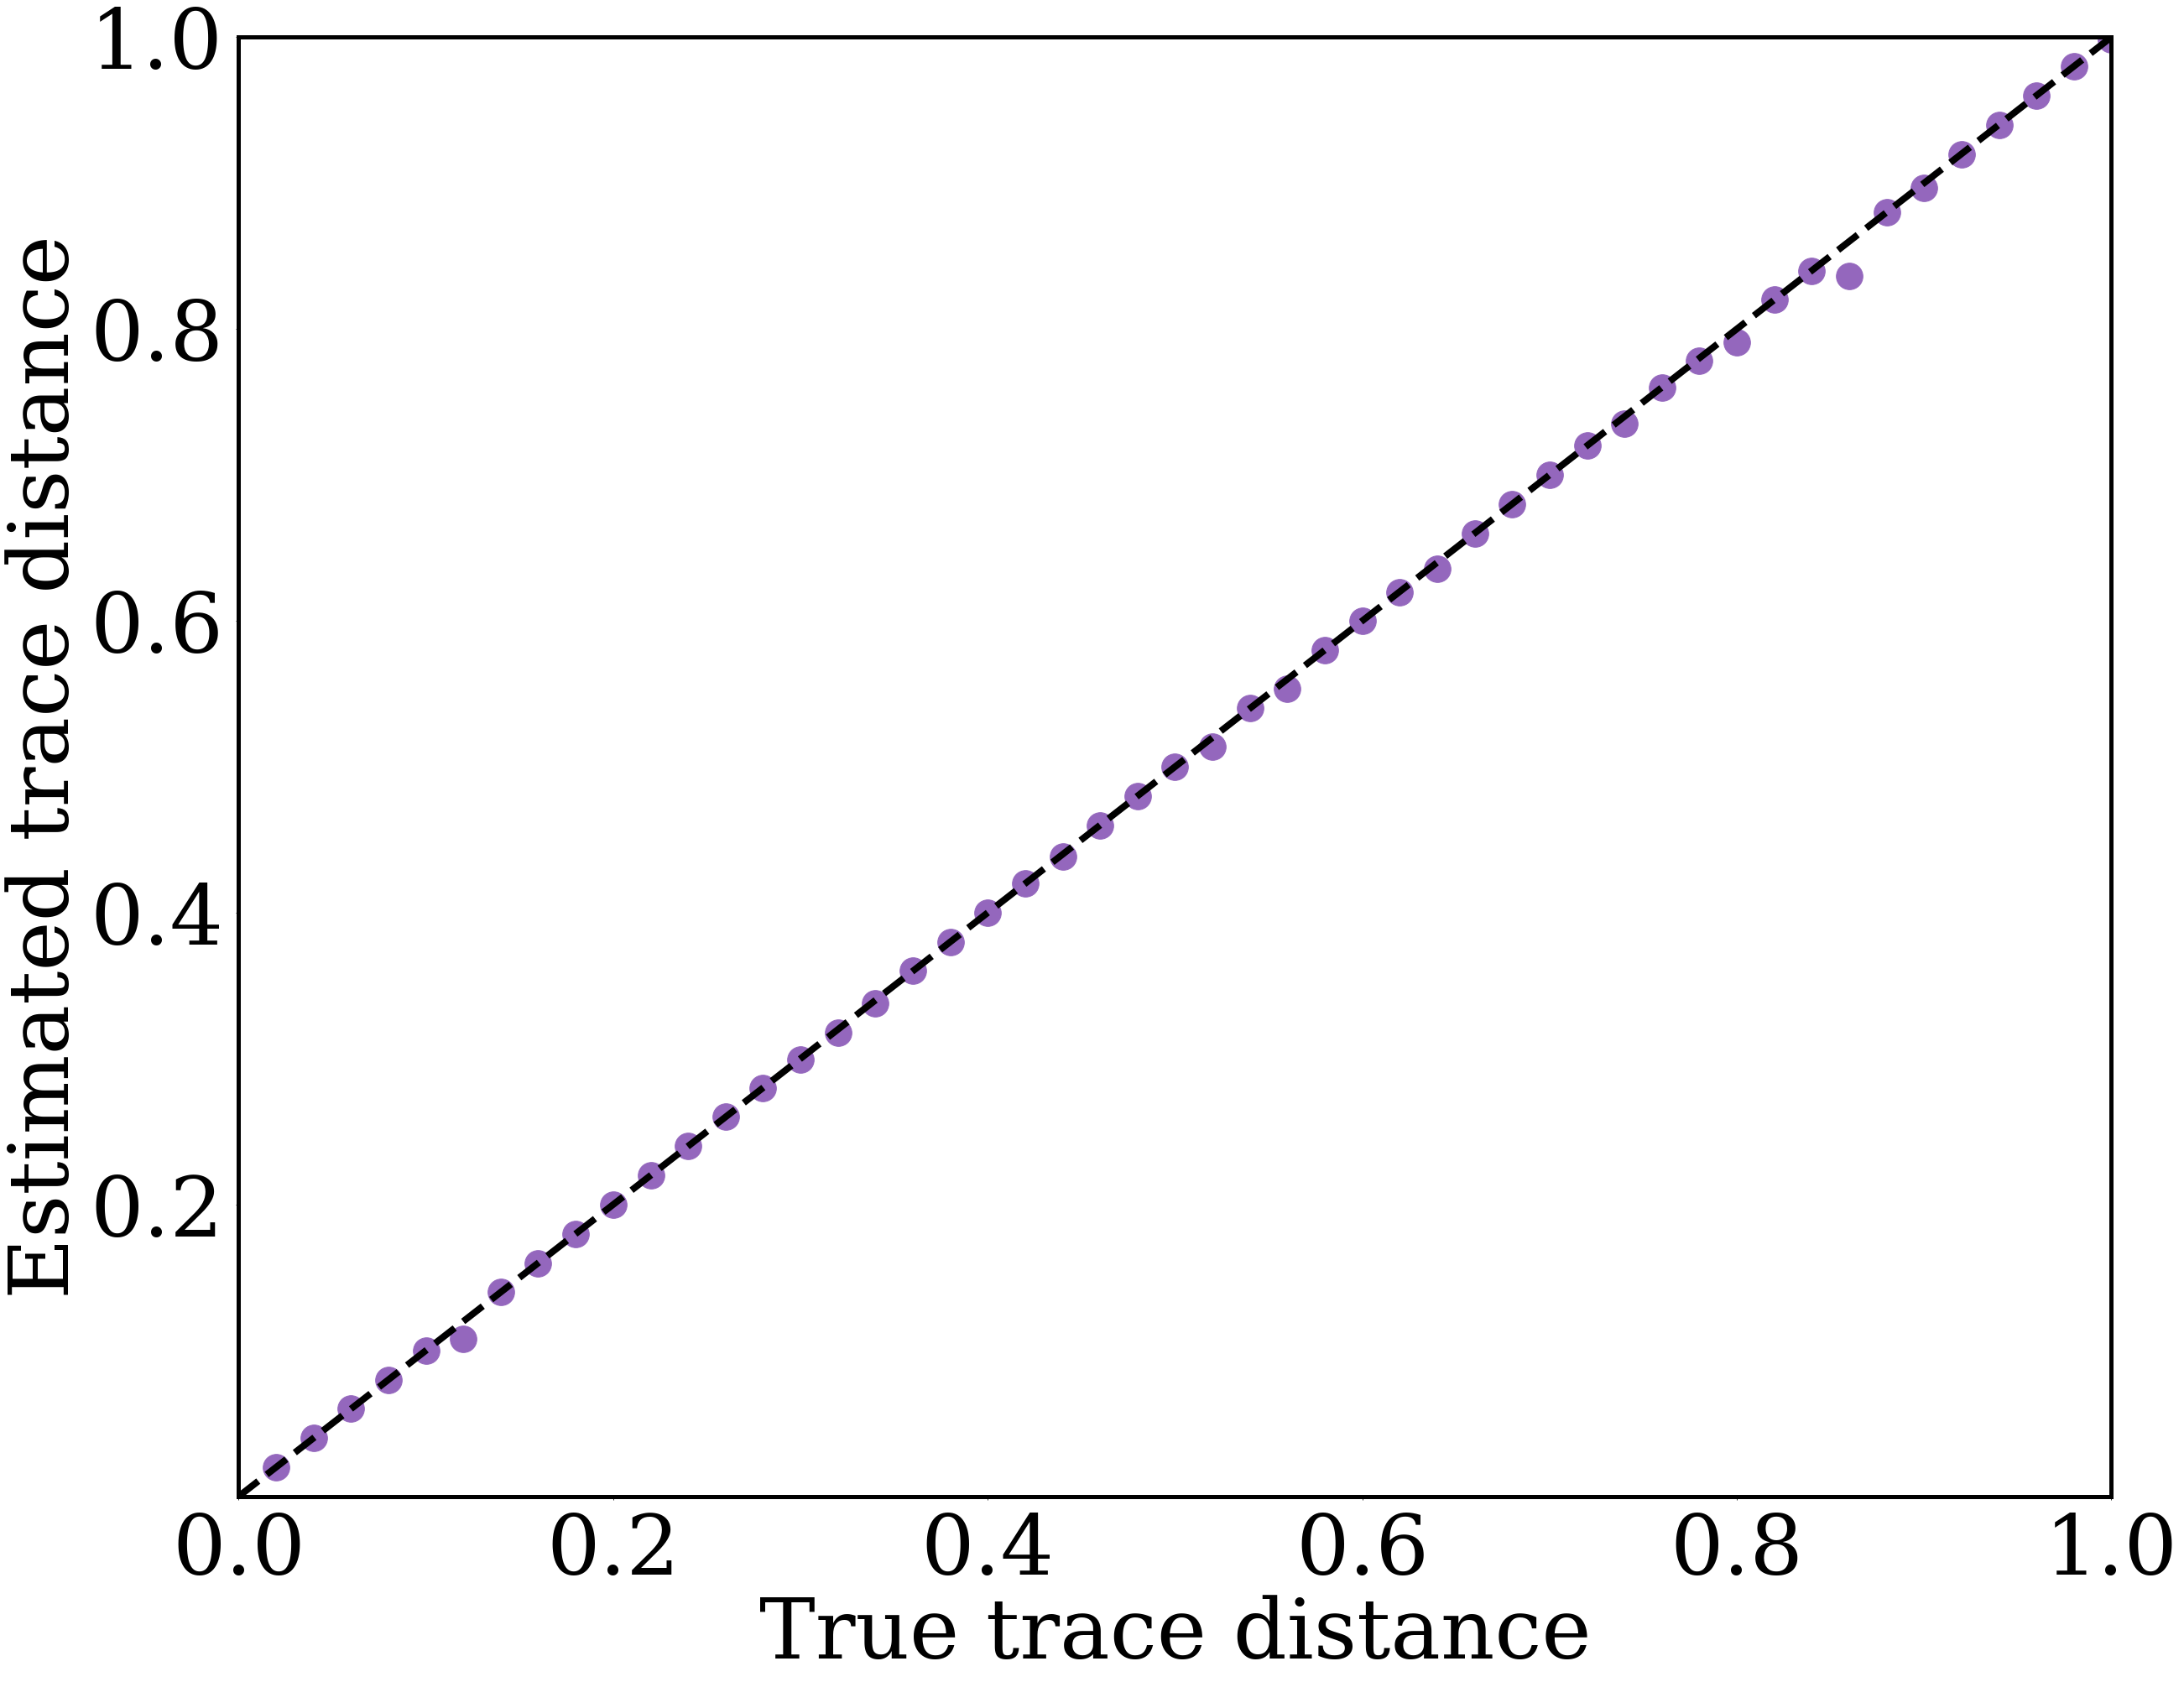

In [24]:
plt.rcParams["figure.figsize"] = (40,32)
plt.plot([0,1],[0,1],'k--',linewidth=8)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("True trace distance")
plt.yticks([0.2,0.4,0.6,0.8,1])
plt.ylabel("Estimated trace distance")
plt.scatter(trueTD2/2,estTD2/2,s=1000,color="tab:purple")

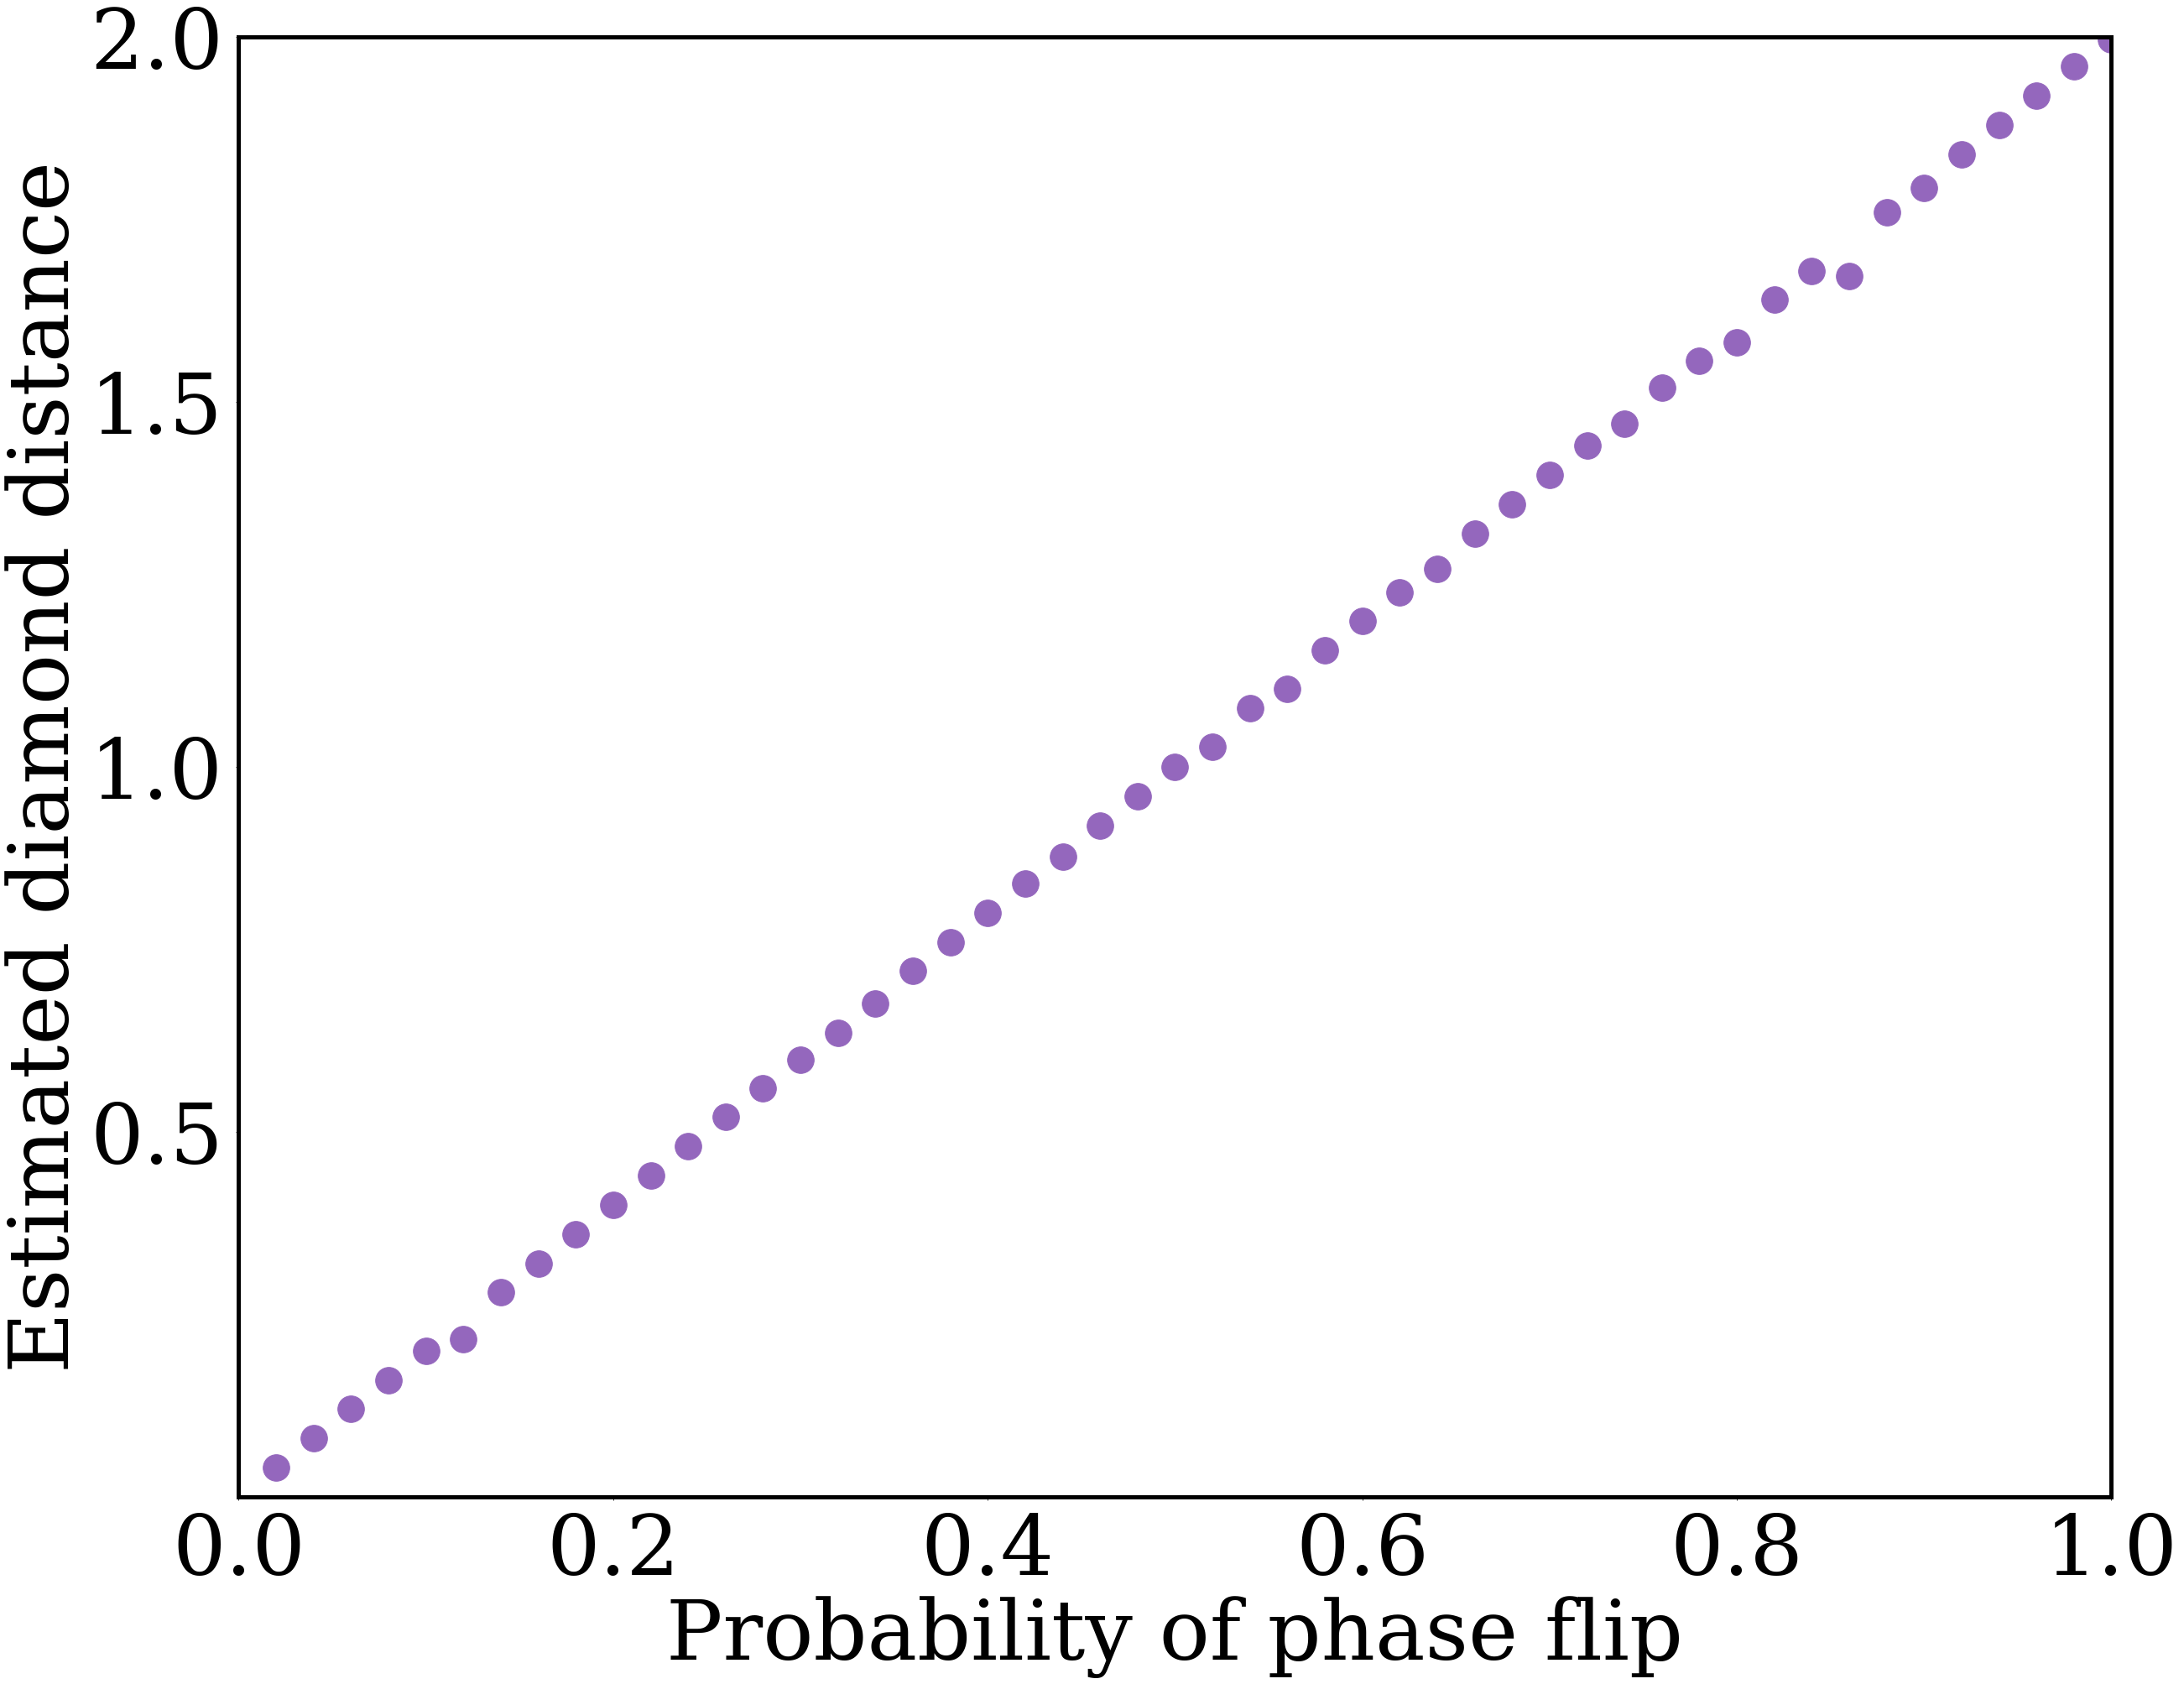

In [37]:
plt.rcParams["figure.figsize"] = (40,32)
plt.xlim(0,1)
plt.ylim(0,2)
plt.ylabel("Estimated diamond distance")
plt.yticks([0.5,1,1.5,2])
plt.xlabel("Probability of phase flip")
plt.scatter(cc+0.5,estTD2,s=1000,color="tab:purple")

In [10]:
np.save("data/Z kraus tru.npy",trueTD2)
np.save("data/Z kraus est.npy",estTD2)

In [25]:
trueTD2 = np.load("data/Z kraus tru.npy")
estTD2 = np.load("data/Z kraus est.npy")
cc = np.linspace(-0.5+1/50,0.5,50)

In [19]:
state = try2.U*q.tensor(q.tensor(q.fock(2),q.fock(2)),q.tensor(q.fock(2),q.fock(2)))

In [49]:
rho = ((state*state.dag()).ptrace([0,3]).full()
np.trace(rho@scipy.linalg.logm(rho)/np.log(2))

(-0.1455822699767837+5.841821364417302e-20j)

In [48]:
np.linalg.eigvals(rho)

array([1.00000000e+00+1.56164916e-18j, 4.95016205e-14-1.56164916e-18j])